

### What dataset do we use?

In this document, given an entire 2017-2018 season's worth of player data from the The Süper Lig, Turkish professional soccer league (≈1,700,000 data points), we generate input (aligning player trajectories based in role and then setting new features based on spatiotemporal data) and output data in order to build model for predicting ball location over the pitch.
Due to losses in data, some matches have been extracted, so the total number of matches used is 299.

### What is our approach?

Our approach is based on the player's role-assignment, rather than the player's individual data. We're given huge set of player spatiotemportal tracking dats. In oreder to build our features set, we should arrange all these data in some particular order, so machine should understand which data it use. We can not randomly pick player's data and use it in data construction. Therefore, using players individual data for analyzing lacks some important contextual concepts.  Football is played by 11 players on each side, but there is an open door for 3 substitution players. We can not also use players' data those aren't in the game, this should cause a lot of noise in the system. For doing so, we developed the role-based analysis.

As in all games, football also has its standard rules for assigning each player role, such as; the rearmost players are defence players, midfielders are players whose position of play is midway, forwards player. Using this information we can assig role to each player.

1. Define which player's in the game.
2. Generate players' average positions based on their position in the timeline of previous 15 minutes.
3. Each minute update their average position.
4. Scale average positions to 105x68 pitch size based on their standard deviation of distributional data.
5. Assing role to each player.


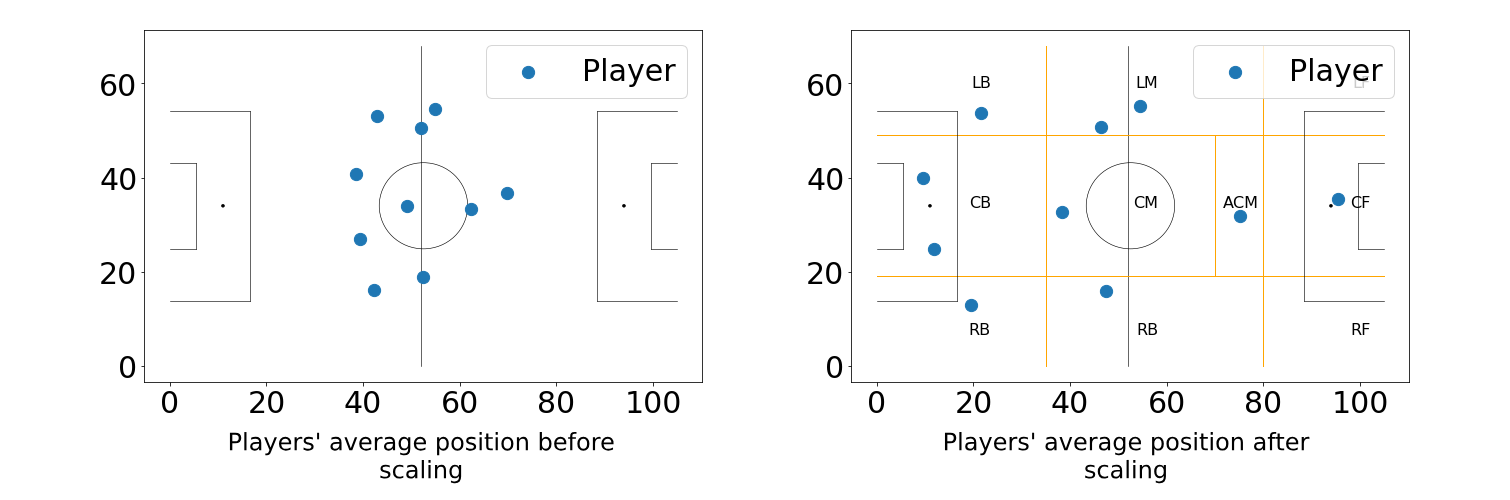


Sometimes we lost player's data, even though he is still in the game (not substituted or set-off). This happens when tagger misses to tag data, the player receives medical treatment out of the pitch, or game is stopped (in this case all players data is null). In this praticualr cases we allply below.   


1. Chenck wheter player is still in game or not (not substituted or set-off).
2. If player's in game check wheter you're receiving his data or not.
3. If we receive his data then use it in the feature construction.

In [15]:
from __future__ import division

import json
import pickle
import pandas as pd
import numpy as np
import math
from scipy.ndimage.interpolation import shift

Function for calculating mean of players x,y positions on the pitch

In [3]:
def caluclate_avrg_pos(c_ap_minutes_step, pos_mean, player, pos_count, activity_count):
    avrg_pos_count = 0 
    for c_ap_minutes in range(0,c_ap_minutes_step):
        pos_mean[player][0] += pos_count[player][0][c_ap_minutes]
        pos_mean[player][1] += pos_count[player][1][c_ap_minutes]
        avrg_pos_count += activity_count[player][c_ap_minutes] 
    if avrg_pos_count!=0:
        pos_mean[player][0] /= avrg_pos_count
        pos_mean[player][1] /= avrg_pos_count
    else:
        pos_mean[player][0] = 0 
        pos_mean[player][1] = 0

Function for checking activity over the specific period of time

In [4]:
def caluclate_activity_count(c_ac_minutes_step, player, activity_count):
    
    activity_count_each = 0 
    for c_ac_minutes in range(0, c_ac_minutes_step):
        activity_count_each += activity_count[player][c_ac_minutes] 
    
    if activity_count_each != 0:
        return 1
    else:
        return 0

Function for calculating last number of non-zero activity occurred in last minute

In [5]:
def caluclate_last_nzero_ac_count(player_gorup_len, activity_count):
    
    last_activity_count = 0
    for player_lac_i in range(0, player_gorup_len):
        if activity_count[player_lac_i][1] !=0:
            last_activity_count += 1
            
    return last_activity_count

Function to find the minute that the last non-zero activty occured in

In [6]:
def caluclate_nzero_activity_count(start, end, player, activity_count):
    
    activity_count_each = 0 
    for c_nz_minutes in range(start, end, -1):
        if activity_count[player][c_nz_minutes-1]!=0:
            return c_nz_minutes-1
        
    return -1

Functions for calculating first 15 min of mean of position data of each player. By that way we'll be able to separately calculate each half mean pos data. 

In [7]:
def fist_time_step_mean_data(half, data_persec_t):
    tmp_time_step_t = 0
    
    for t in data_persec_t:

        first_time_step_i = int(t['minute'])*60 + int(t['second'])
        x_pos = t['xpos']
        y_pos = t['ypos']
        team_id_t = int(t['teamId'])
        jersey_number_t = int(t['jerseyNumber'])
        has_ball_teamId_t = int(t['hasballTeamId'])
        math_half = int(t['half'])


        sec = first_time_step_i-(half-1)*45*60
        time_step = math.floor(sec/60)

        if sec==threshold_second:
            break
            
        if tmp_time_step_t == time_step:
            
            tmp_time_step_t += 1
            
            for player_home in range(0, len(home_team_player)):
                home_pos_count_minutes[player_home][0] = (shift(home_pos_count_minutes[player_home][0], -1, cval=0))
                home_pos_count_minutes[player_home][1] = (shift(home_pos_count_minutes[player_home][1], -1, cval=0))
                home_activity_count_minutes[player_home] = (shift(home_activity_count_minutes[player_home], -1, cval=0))
                
            for player_away in range(0, len(away_team_player)):
                away_pos_count_minutes[player_away][0] = (shift(away_pos_count_minutes[player_away][0], -1, cval=0))
                away_pos_count_minutes[player_away][1] = (shift(away_pos_count_minutes[player_away][1], -1, cval=0))
                away_activity_count_minutes[player_away] = (shift(away_activity_count_minutes[player_away], -1, cval=0))

            

        if math_half == half:
            

            if team_id_t == home_team_id:
                
                player_home = home_dict[str(jersey_number_t)]
                if player_positionId['homeTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                    if x_pos!=0 and y_pos !=0:    
                        home_pos_count_minutes[player_home][0][minutes_step-1] += x_pos
                        home_pos_count_minutes[player_home][1][minutes_step-1] += y_pos
                        home_activity_count_minutes[player_home][minutes_step-1] +=1 

                elif has_ball_teamId_t == away_team_id:
                    if x_pos!=0 and y_pos !=0:    
                        home_pos_count_minutes[player_home][0][minutes_step-1] += x_pos
                        home_pos_count_minutes[player_home][1][minutes_step-1] += y_pos
                        home_activity_count_minutes[player_home][minutes_step-1] +=1 

            elif team_id_t == away_team_id:

                player_away = away_dict[str(jersey_number_t)]
                if player_positionId['awayTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                    if x_pos!=0 and y_pos!=0:
                        away_pos_count_minutes[player_away][0][minutes_step-1] += x_pos
                        away_pos_count_minutes[player_away][1][minutes_step-1] += y_pos
                        away_activity_count_minutes[player_away][minutes_step-1] +=1  

                elif has_ball_teamId_t == home_team_id:
                    if x_pos!=0 and y_pos!=0:
                        away_pos_count_minutes[player_away][0][minutes_step-1] += x_pos
                        away_pos_count_minutes[player_away][1][minutes_step-1] += y_pos
                        away_activity_count_minutes[player_away][minutes_step-1] +=1  

                        
    return home_activity_count_minutes, away_activity_count_minutes

Function to define pitch index and role

In [8]:
def define_role(x, y, pitch_value, gk_state):
    
    # gk_state==1 := golakeeper
    
    if gk_state==1:
        return 10
    else:
        for pitch_i in range(0,10):
            if x>=pitch_value[pitch_i][0] and x<=pitch_value[pitch_i][1] and y>=pitch_value[pitch_i][2] and y<=pitch_value[pitch_i][3]:
                return pitch_i
    return -1

def define_pitch_index(x,y):
    
    
    Xi=math.floor(x/5)
    if y<=60:
        Yj = math.floor(y/5)+1
    else:
        Yj = math.floor(y/4)+1
            
    
    index = Xi*14 + Yj

    return index

Function to define features based on pitch index and role

In [9]:
def speed_group(speed):
    
    if speed<=2: # random Spped (V)
        return 0
    elif speed<=3: # HIR
        return 1
    else: # Sprint (S)
        return 2
    
def feature_adding(f_r, f_group, f_x1, f_x2, f_y2, f_speed, f_features_v, f_features_count):
    f_features_v[f_r][f_group*4] += f_x2 
    f_features_v[f_r][f_group*4+1] += f_y2 
    f_features_v[f_r][f_group*4+2] += f_speed 
    f_features_v[f_r][f_group*4+3] += round((f_x2-f_x1),2)

    f_features_count[f_r][f_group] += 1
    
def features_adjust(f_features_v, f_features_count):
    
    for f_a_i in range(0,10):
        for f_a_j in range(0,3):
            
            f_count = int(f_features_count[f_a_i][f_a_j])
            
            if f_count==0:
                f_features_v[f_a_i][f_a_j*4 :f_a_j*4+4] = 0
            else:
                f_features_v[f_a_i][f_a_j*4 :f_a_j*4+4] = f_features_v[f_a_i][f_a_j*4 :f_a_j*4+4] / f_count

            
                deltaX = int(f_features_v[f_a_i][f_a_j*4+3])

                if deltaX<1:
                    f_features_v[f_a_i][f_a_j*4+3] = -1
                elif deltaX>1:
                    f_features_v[f_a_i][f_a_j*4+3] = 1
                else:
                    f_features_v[f_a_i][f_a_j*4+3] = 0 
                    

                

def feature_generation(r,x1,x2,y2,speed, features_v,features_count):
    
    if r==0: # LB
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==1: # CB
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==2: # RB
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==3: # LM
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==4: # CM
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==5: # RM
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==6: # ACM
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==7: # LF
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==8: # CF
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)

    elif r==9: # RF
        group = speed_group(speed)
        feature_adding(r,group,x1,x2,y2,speed,features_v,features_count)


Function for sclaing player avrg position to the same size with pitch

In [10]:
def scale_linear(rawpoints, high, low):
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    return high - (((high - low) * (maxs - rawpoints)) / rng)

In [11]:
with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)
    

minutes_step = 15
data_height = 103 # number of minutes in per match



# pitch position index - 0:LB, 1:CB, 2:RB, 3:LM, 4:CM, 5:RM, 6:ACM, 7:LF, 8:CF, 9:RF
pitch_positions = [[0, 35, 0, 19],[0, 35, 19, 49], [0, 35, 49, 68],
                   [35, 80, 0, 19],[35, 70, 19, 49], [35, 80, 49, 68], [70, 80, 19, 49],
                   [80, 105, 0, 19],[80, 105, 19, 49], [80, 105, 49, 68]]

# pitch index: 295 distinct area on the pitch (5x5)

pitch_index = np.zeros(shape=(295, 5), dtype=np.float)

x_axis = []
y_axis = []

for i in range(0,106,+5):
    x_axis.append(i)
    
for i in range(0,61,+5):
    y_axis.append(i)
y_axis.append(64)
y_axis.append(68)


pitch_index[0] = [0,0,0,0,0]

index = 1
for i in range(0, len(x_axis)-1):
    for j in range(0, len(y_axis)-1):
        pitch_index[index] = [ index, x_axis[i], x_axis[i+1], y_axis[j], y_axis[j+1] ]
        index+=1


role_count_cvs_headers = "LB-V, LB-HIR, LB-S, CB-V, CB-HIR, CB-S, RB-V, RB-H, RB-S, LM-V, LM-H, LM-S, CM-V, CM-H, CM-S, RM-V, RM-H, RM-S, ACM-V, ACM-H, ACM-S, LF-V, LF-H, LF-S, CF-V, CF-H, CF-V, RF-V, RF-H, RF-S"        
   
        
home_cvs = []



for match_data in matches:

    
    id = int(match_data['id'])
    # id!=60617 and id!=60634 and id!=60696 and id!=60706 and id!=60821 and id!=60845 and id!=116001326 and 
    if id==60565:

        print("\nMatch id:" + str(id))


        
        # defining 3 distinct id in game
        referee_id = 0
        home_team_id = int(match_data['homeId']) 
        away_team_id = int(match_data['awayId']) 


        # home and away player list
        home_team_player = []
        home_goal_keeper = []
        away_team_player = []
        away_goal_keeper = []
        
        
        
        # all data
        all_data = []
        all_data_count = []
        


        # home_nonzero
        home_player_count_pitch = []
        home_prev_count = 11

        # home_nonzero
        away_player_count_pitch = []
        away_prev_count = 11

        # player dicts
        home_dict = {} 
        away_dict = {}
        
        # features vectors
        home_feature_vector = np.zeros(shape=(10, 12), dtype=np.float)
        away_feature_vector = np.zeros(shape=(10, 12), dtype=np.float)
        
        # features vectors count
        home_feature_count = np.zeros(shape=(10, 3), dtype=np.float)
        away_feature_count = np.zeros(shape=(10, 3), dtype=np.float)
        
        # features for Refreee and GKs
        refree_features = np.zeros(shape=(1,4), dtype=np.float)
        GK_home_features = np.zeros(shape=(1,4), dtype=np.float)
        GK_away_features = np.zeros(shape=(1,4), dtype=np.float)
        
        # ball position
        ball_pos_index = np.zeros(shape=(1, 1), dtype=np.int)
        
        
        # game duration
        whole_game_duration = 0

        # players position ID 
        player_positionId = {'homeTeam' : {}, 'awayTeam' : {}}


        with open('../data/match_' + str(id) + '/roster_data_' + str(id) + '.json', 'r') as file:
            match_squad = json.load(file)

        for roaster in match_squad:
            if roaster['teamId'] == home_team_id:
                home_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['homeTeam'][roaster['jerseyNumber']] = roaster['positionId'] 
                if roaster['positionId'] == 1:
                    home_goal_keeper.append(str(roaster['jerseyNumber']))


            elif roaster['teamId'] == away_team_id:
                away_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['awayTeam'][roaster['jerseyNumber']] = roaster['positionId']
                if roaster['positionId'] == 1:
                    away_goal_keeper.append(str(roaster['jerseyNumber']))


        # home players dict data
        home_team_player.sort(key=int)
        home_goal_keeper.sort(key=int)
        home_val = np.arange(0, len(home_team_player))
        home_dict = dict(zip(home_team_player, home_val))
        home_dict_reverse = dict(zip(home_val, home_team_player))


        # away players dict data
        away_team_player.sort(key=int)
        away_goal_keeper.sort(key=int)
        away_val = np.arange(0, len(away_team_player))
        away_dict = dict(zip(away_team_player, away_val))
        away_dict_reverse = dict(zip(away_val, away_team_player))

        # home and away team players' status[0: not playing, 1: playing, 2-left the game], enter status[0: enter 1st half, 1: enter second half],
        # enter time, and duration, red card
        home_dur_in_out = np.zeros(shape=(len(home_team_player), 5), dtype=np.float)
        away_dur_in_out = np.zeros(shape=(len(away_team_player), 5), dtype=np.float)


        with open('../data/match_' + str(id) + '/players_data_' + str(id) + '.json', 'r') as file:
            player_data = json.load(file)


        for player in player_data:
            jersey_number = player['jerseyNumber']
            if player['teamId'] == home_team_id:
                home_dur_in_out[home_dict[str(jersey_number)]][3] = player['duration']
                home_dur_in_out[home_dict[str(jersey_number)]][4] = player['redCard']



            elif player['teamId'] == away_team_id:
                away_dur_in_out[away_dict[str(jersey_number)]][3] = player['duration']
                away_dur_in_out[away_dict[str(jersey_number)]][4] = player['redCard']



        # home and away team player pos and activity count: 0-xpos, 1-ypos
        home_pos_count = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
        home_activity_count = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
        home_activity_count_all = np.zeros(shape=(len(home_team_player), 2), dtype=np.int)
        home_act_nozero = [0,0] # number non-zero activity_count_all


        away_pos_count = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
        away_activity_count = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)
        away_activity_count_all = np.zeros(shape=(len(away_team_player), 2), dtype=np.int)
        away_act_nozero = [0,0] # number non-zero activity_count_all
        
        # team positions
        home_team_role =  np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
        away_team_role =  np.zeros(shape=(len(away_team_player), 1), dtype=np.int)


        # home and away team player count data for 10 min: 0-xpos, 1-ypos / 0-1min, 1-2min... 9-10min 
        home_pos_count_minutes = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        home_pos_count_minutes2 = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes2 = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes2 = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)


        # home and away team mean pos data: 0-xpos, 1-ypos
        home_pos_mean = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
        away_pos_mean = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)


        # players's and refree's previous and next x data
        home_x_data = np.zeros(shape=(len(home_team_player),2), dtype=np.float)
        away_x_data = np.zeros(shape=(len(away_team_player),2), dtype=np.float)
        referee_x_data = [0,0]


        with open('../data/match_' + str(id) + '/per_sec_data_' + str(id) + '.json', 'r') as file:
            data_persec = json.load(file)

        home_pos_count_minutes = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)

        # create first average positon data for assigning player position at the 1st half
        # temporary t
        
        home_activity_count_all[0: len(home_team_player)] = 0
        away_activity_count_all[0: len(away_team_player)] = 0

        
        tmp_t = 0
        tmp_t_2 = 0
        shift_times_right = 0
        
        # threshol second:
        threshold_second = 60

        # 1st half duration
        first_half_duration = 0

        home_nonzero = 11
        away_nonzero = 11

        prev_home_nonzero = 11
        prev_away_nonzero = 11


        # temporary half
        tmp_half = 1

        c_activity_value = 0
        c_home_activity_each = 0
        c_away_activity_each = 0

        while c_activity_value==0:

            c_home_activity_each = 0
            c_away_activity_each = 0

            a,b = fist_time_step_mean_data(1, data_persec)


            for player_home in range(0, len(home_team_player)):
                res = caluclate_activity_count(minutes_step, player_home, a)
                c_home_activity_each += res

            for player_away in range(0, len(away_team_player)):
                res = caluclate_activity_count(minutes_step, player_away, b)
                c_away_activity_each += res

            if c_home_activity_each == 11 and c_away_activity_each == 11:
                c_activity_value = 1

            threshold_second += 60  

        threshold_second -= 1
        tmp_t_2 = threshold_second 
        
#         print("1st half start: " + str(threshold_second) + " sec")
        
        
        for d in data_persec:

            match_half_t = int(d['half'])

            # create first average positon data for assigning player at the 2nd half
            if match_half_t != tmp_half and match_half_t==2:
                tmp_half = match_half_t
                shift_times_right = 0

                tmp_t = 45*60

                activity_home_nonzero = 0
                activity_away_nonzero = 0
                home_break_subs = []
                away_break_subs = []
                home_break_subs_after = []
                away_break_subs_after = []

                for player_home in range(0, len(home_team_player)):
                    if home_pos_mean[player_home][0] !=0:
                            activity_home_nonzero += 1
                            home_break_subs.append(1)
                    else:
                        home_break_subs.append(0)


                for player_away in range(0, len(away_team_player)):
                    if away_pos_mean[player_away][0] !=0:
                            activity_away_nonzero += 1
                            away_break_subs.append(1)
                    else:
                        away_break_subs.append(0)

                home_nonzero = activity_home_nonzero
                away_nonzero = activity_away_nonzero


                # clear home team data
                home_pos_count[0: len(home_team_player)] = 0
                home_activity_count[0: len(home_team_player)] = 0 
                home_activity_count_all[0: len(home_team_player)] = 0
                home_act_nozero = [0,0]
                home_pos_count_minutes[0: len(home_team_player)] = 0
                home_activity_count_minutes[0: len(home_team_player)] = 0
                home_pos_mean[0: len(home_team_player)] = 0

                # clear away team data
                away_pos_count[0: len(away_team_player)] = 0
                away_activity_count[0: len(away_team_player)] = 0 
                away_activity_count_all[0: len(away_team_player)] = 0
                away_act_nozero = [0,0]
                away_pos_count_minutes[0: len(away_team_player)] = 0
                away_activity_count_minutes[0: len(away_team_player)] = 0
                away_pos_mean[0: len(away_team_player)] = 0
                
                
                
                # features vectors
                home_feature_vector[:]=0
                away_feature_vector[:]=0

                # features vectors count
                home_feature_count[:]=0
                away_feature_count[:]=0
                
                # index 
                ball_pos_index[0][0] = 0
                
                
                refree_features[:]=0
                GK_home_features[:]=0
                GK_away_features[:]=0
                
                
                # previus and next x data
                home_x_data[:]=0
                away_x_data[:]=0
                referee_x_data = [0,0]


                threshold_second = 60

                c_activity_value = 0
                c_home_activity_each = 0
                c_away_activity_each = 0

                while c_activity_value==0:

                    c_home_activity_each = 0
                    c_away_activity_each = 0

                    home_break_subs_after = []
                    away_break_subs_after = []

                    a,b = fist_time_step_mean_data(2, data_persec)

                    for player_home in range(0, len(home_team_player)):
                        res = caluclate_activity_count(minutes_step, player_home, a)
                        c_home_activity_each += res
                        home_break_subs_after.append(res)

                    for player_away in range(0, len(away_team_player)):
                        res = caluclate_activity_count(minutes_step, player_away, b)
                        c_away_activity_each += res
                        away_break_subs_after.append(res)


                    if c_home_activity_each == activity_home_nonzero and c_away_activity_each == activity_away_nonzero:
                        c_activity_value = 1

                    threshold_second += 60


                for player_home_2 in range(0, len(home_team_player)):
                    if home_break_subs_after[player_home_2]==0 and home_break_subs[player_home_2]==1:
                        home_dur_in_out[player_home_2][0] = 2 # menas goal keepr has left the game

                for player_away_2 in range(0, len(away_team_player)):
                    if away_break_subs_after[player_away_2]==0 and away_break_subs[player_away_2]==1:
                        away_dur_in_out[player_away_2][0] = 2 # menas goal keepr has left the game

                threshold_second -= 1
                tmp_t_2 = threshold_second 



            i = int(d['minute'])*60 + int(d['second'])
            x_pos = round(d['xpos'],2)
            y_pos = round(d['ypos'],2)
            team_id_t = int(d['teamId'])
            speed_t = round(d['speed'],2)
            jersey_number_t = int(d['jerseyNumber'])
            has_ball_teamId_t = int(d['hasballTeamId'])
            has_ball_jerseyId_t = int(d['hasballJerseyNumber'])


            # find out how long did 1st half last
            if match_half_t == 1:
                first_half_duration = i


            if i%60==59:

                if team_id_t == home_team_id:
                    player = home_dict[str(jersey_number_t)]
                    home_activity_count_all[player][1] = 1

                elif team_id_t == away_team_id:
                    player = away_dict[str(jersey_number_t)]
                    away_activity_count_all[player][1] = 1
      
            if i%60!=0:    

                if team_id_t == home_team_id:

                    if home_dur_in_out[home_dict[str(jersey_number_t)]][0] == 0:
                        home_dur_in_out[home_dict[str(jersey_number_t)]][0] = 1 # indicates that a player is in game 
                        home_dur_in_out[home_dict[str(jersey_number_t)]][1] = match_half_t # enter half
                        home_dur_in_out[home_dict[str(jersey_number_t)]][2] = i  # enter time


                        plyr_position = player_positionId['homeTeam'][jersey_number_t]
                        player = home_dict[str(jersey_number_t)]
                        home_pos_count_minutes[player][1][minutes_step-1] += 34
                        home_activity_count_minutes[player][minutes_step-1] +=1


                        if plyr_position == 1:
                            home_pos_count_minutes[player][0][minutes_step-1] += 10
                        elif plyr_position == 2:
                            home_pos_count_minutes[player][0][minutes_step-1] += 38
                        elif plyr_position == 3:
                            home_pos_count_minutes[player][0][minutes_step-1] += 58
                        else:
                            home_pos_count_minutes[player][0][minutes_step-1] += 78

                    if i<((home_dur_in_out[home_dict[str(jersey_number_t)]][2])+60) and home_dur_in_out[home_dict[str(jersey_number_t)]][0] == 1:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1 

                    elif player_positionId['homeTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1

                    elif has_ball_teamId_t == away_team_id:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1 

                elif team_id_t == away_team_id:

                    if away_dur_in_out[away_dict[str(jersey_number_t)]][0] == 0:
                        away_dur_in_out[away_dict[str(jersey_number_t)]][0] = 1 # indicates that a player is in game
                        away_dur_in_out[away_dict[str(jersey_number_t)]][1] = match_half_t # enter half 
                        away_dur_in_out[away_dict[str(jersey_number_t)]][2] = i #enter time

                        plyr_position = player_positionId['awayTeam'][jersey_number_t]
                        player = away_dict[str(jersey_number_t)]
                        away_pos_count_minutes[player][1][minutes_step-1] += 34
                        away_activity_count_minutes[player][minutes_step-1] +=1


                        if plyr_position == 1:
                            away_pos_count_minutes[player][0][minutes_step-1] += 10
                        elif plyr_position == 2:
                            away_pos_count_minutes[player][0][minutes_step-1] += 38
                        elif plyr_position == 3:
                            away_pos_count_minutes[player][0][minutes_step-1] += 58
                        else:
                            away_pos_count_minutes[player][0][minutes_step-1] += 78


                    if i<((away_dur_in_out[away_dict[str(jersey_number_t)]][2])+60) and away_dur_in_out[away_dict[str(jersey_number_t)]][0] == 1:
                        if x_pos!=0 and y_pos!=0:
                            away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                            away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                            away_activity_count[away_dict[str(jersey_number_t)]] +=1

                    elif player_positionId['awayTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                        away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                        away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                        away_activity_count[away_dict[str(jersey_number_t)]] +=1

                    elif has_ball_teamId_t == home_team_id:
                         if x_pos!=0 and y_pos!=0:
                            away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                            away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                            away_activity_count[away_dict[str(jersey_number_t)]] +=1 

             
            # shifing last index of 15min arry (period of 15min) with last min data
            # and calculate mena position of each player each min based on previus 10 min
            if i%60 == 0 and tmp_t != i+1 and (i-(match_half_t-1)*45*60)>threshold_second:


                tmp_t = i+1

                prev_home_nonzero = home_nonzero
                home_nonzero = 0

                prev_away_nonzero = away_nonzero
                away_nonzero = 0


                if shift_times_right !=0:
                    for player_home in range(0, len(home_team_player)):

                        home_pos_count_minutes[player_home][0] = (shift(home_pos_count_minutes[player_home][0], -1, cval=0))
                        home_pos_count_minutes[player_home][1] = (shift(home_pos_count_minutes[player_home][1], -1, cval=0))
                        home_activity_count_minutes[player_home] = (shift(home_activity_count_minutes[player_home], -1, cval=0))

                        home_pos_count_minutes[player_home][0][minutes_step-1] = home_pos_count[player_home][0]
                        home_pos_count_minutes[player_home][1][minutes_step-1] = home_pos_count[player_home][1]
                        home_activity_count_minutes[player_home][minutes_step-1] = home_activity_count[player_home]


                    for player_away in range(0, len(away_team_player)):

                        away_pos_count_minutes[player_away][0] = (shift(away_pos_count_minutes[player_away][0], -1, cval=0))
                        away_pos_count_minutes[player_away][1] = (shift(away_pos_count_minutes[player_away][1], -1, cval=0))
                        away_activity_count_minutes[player_away] = (shift(away_activity_count_minutes[player_away], -1, cval=0))

                        away_pos_count_minutes[player_away][0][minutes_step-1] = away_pos_count[player_away][0]
                        away_pos_count_minutes[player_away][1][minutes_step-1] = away_pos_count[player_away][1]
                        away_activity_count_minutes[player_away][minutes_step-1] = away_activity_count[player_away]


                shift_times_right = 1


                # clear home team
                home_pos_count[0: len(home_team_player)] = 0
                home_activity_count[0: len(home_team_player)] = 0

                # clear away team
                away_pos_count[0: len(away_team_player)] = 0
                away_activity_count[0: len(away_team_player)] = 0


                home_pos_mean[0:len(home_team_player)] = 0
                home_act_nozero = [0,0]

                away_pos_mean[0:len(away_team_player)] = 0
                away_act_nozero = [0,0]



                for player_home in range(0, len(home_team_player)):
                    jersey_n = int(home_dict_reverse[player_home])
                    if player_positionId['homeTeam'][jersey_n] == 1 and home_dur_in_out[player_home][0]==1 and home_activity_count_all[player_home][1] == 0:
                        action_status_exit = 0
                        
                        if home_dur_in_out[player_home][4]==1:
                            enter_half = home_dur_in_out[player_home][1]
                            enter_time = home_dur_in_out[player_home][2]
                            p_game_play_dur = home_dur_in_out[player_home][3]

                            h = match_half_t
                            f_h_d= first_half_duration

                            if enter_half == 1:
                                current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                            elif enter_half == 2:
                                current_play_dur = math.floor( (i - enter_time)/60 )

                            if current_play_dur < p_game_play_dur:


                                for gk_i in home_goal_keeper:
                                    if home_activity_count_all[home_dict[str(gk_i)]][1] !=0:
                                        home_dur_in_out[player_home][0] = 2 # menas goal keepr has left the game
                                        home_pos_mean[player_home][0] = 0 
                                        home_pos_mean[player_home][1] = 0
                                        action_status_exit = 1
                        else:
                            for gk_i in home_goal_keeper:
                                if home_activity_count_all[home_dict[str(gk_i)]][1] !=0:
                                    home_dur_in_out[player_home][0] = 2 # menas goal keepr has left the game
                                    home_pos_mean[player_home][0] = 0 
                                    home_pos_mean[player_home][1] = 0
                                    action_status_exit = 1
                            

                        if action_status_exit == 0:
                            home_activity_count_all[player_home][1] = 1

                    if (home_activity_count_all[player_home][0]==1):
                        home_act_nozero[0] += 1

                    if (home_activity_count_all[player_home][1]==1):
                        home_act_nozero[1] += 1
                        
                

                for player_away in range(0, len(away_team_player)):
                    jersey_n = int(away_dict_reverse[player_away])
                    if player_positionId['awayTeam'][jersey_n] == 1 and away_dur_in_out[player_away][0]==1 and away_activity_count_all[player_away][1] == 0:
                        action_status_exit = 0
                        
                        if away_dur_in_out[player_away][4]==1:

                            # player current and whole game duration durng match
                            enter_half = away_dur_in_out[player_away][1]
                            enter_time = away_dur_in_out[player_away][2]
                            p_game_play_dur = away_dur_in_out[player_away][3]

                            h = match_half_t
                            f_h_d= first_half_duration

                            if enter_half == 1:
                                current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                            elif enter_half == 2:
                                current_play_dur = math.floor( (i - enter_time)/60 )

                            if current_play_dur < p_game_play_dur:

                                for gk_i in away_goal_keeper:
                                    if away_activity_count_all[away_dict[str(gk_i)]][1] !=0:
                                        away_dur_in_out[player_away][0] = 2 # menas goal keepr has left the game
                                        away_pos_mean[player_away][0] = 0 
                                        away_pos_mean[player_away][1] = 0
                                        action_status_exit = 1
                        else:
                            for gk_i in away_goal_keeper:
                                if away_activity_count_all[away_dict[str(gk_i)]][1] !=0:
                                    away_dur_in_out[player_away][0] = 2 # menas goal keepr has left the game
                                    away_pos_mean[player_away][0] = 0 
                                    away_pos_mean[player_away][1] = 0
                                    action_status_exit = 1
                            
                        if action_status_exit == 0:
                            away_activity_count_all[player_away][1] = 1


                    if (away_activity_count_all[player_away][0]!=0):
                        away_act_nozero[0] += 1

                    if (away_activity_count_all[player_away][1]!=0):
                        away_act_nozero[1] += 1

                home_subs_count_check = 0
                home_subs_count_id = 0
                home_2subs_array_in = []
                home_2subs_array_out = []


                for player_home in range(0, len(home_team_player)):
                  

                    if home_activity_count_all[player_home][1] != 0 and home_dur_in_out[player_home][0]==1:

                        caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)

                        if home_act_nozero[0]-home_act_nozero[1]<0 and home_act_nozero[0]!=0 and home_activity_count_all[player_home][0] == 0:
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0
                            home_activity_count_all[player_home][1] = 0


                    elif home_activity_count_all[player_home][1] == 0 and home_dur_in_out[player_home][0]==1 and home_dur_in_out[player_home][4]==1: 
                        # player current and whole game duration durng match


                        enter_half = home_dur_in_out[player_home][1]
                        enter_time = home_dur_in_out[player_home][2]
                        p_game_play_dur = home_dur_in_out[player_home][3]

                        h = match_half_t
                        f_h_d= first_half_duration

                        if enter_half == 1:
                            current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                        elif enter_half == 2:
                            current_play_dur = math.floor( (i - enter_time)/60 )

                        if current_play_dur < p_game_play_dur:
                            caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)
                            home_activity_count_all[player_home][1] = 1
                        else:
                            home_dur_in_out[player_home][0] = 2
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0


                    elif home_activity_count_all[player_home][1] == 0 and home_dur_in_out[player_home][0]==1:

                        if (home_act_nozero[0] == home_act_nozero[1]):
                            home_dur_in_out[player_home][0]=2
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0

                        elif home_act_nozero[0] > home_act_nozero[1]:
                            caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)
                            home_activity_count_all[player_home][1] = 1
                            home_subs_count_check += 1
                            home_2subs_array_out.append(player_home)
                            home_subs_count_id = player_home

                    else:

                        home_pos_mean[player_home][0] = 0 
                        home_pos_mean[player_home][1] = 0


                for player_home in range(0, len(home_team_player)):
                    if home_subs_count_check >=1 and (home_act_nozero[0]-home_act_nozero[1]==1):

                        d = caluclate_nzero_activity_count(minutes_step, 0, home_subs_count_id, home_activity_count_minutes)
                        if home_activity_count_all[player_home][0] == 0 and home_activity_count_all[player_home][1] == 1:
                            
                            if d==14:
                                d-=2
                            result = caluclate_nzero_activity_count(minutes_step, d+1, player_home, home_activity_count_minutes)
                            if result != -1:
                                home_2subs_array_in.append(player_home)

                    home_activity_count_all[player_home][0] = home_activity_count_all[player_home][1]
                    home_activity_count_all[player_home][1] = 0



                # number of last non-zero activties
                home_last_nz_act_count = caluclate_last_nzero_ac_count(len(home_team_player), home_activity_count_all)



                if home_last_nz_act_count == prev_home_nonzero and len(home_2subs_array_out)==2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        if home_activity_count_minutes[player][minutes_step-1] == 0:
                            home_dur_in_out[player][0] = 2
                            home_activity_count_all[player][0] = 0
                            home_pos_mean[player][0] = 0
                            home_pos_mean[player][1] = 0


                if len(home_2subs_array_out)>=2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        home_activity_count_all[player][0] = 1
                        caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)


                if len(home_2subs_array_in) == 2 and len(home_2subs_array_out)==2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        home_dur_in_out[player][0] = 2
                        home_activity_count_all[player][0] = 0
                        home_pos_mean[player][0] = 0
                        home_pos_mean[player][1] = 0

                if len(home_2subs_array_in) == 1 and len(home_2subs_array_out)>=2:
                    player = home_2subs_array_in[0]
                    home_activity_count_all[player][0] = 0
                    home_pos_mean[player][0] = 0
                    home_pos_mean[player][1] = 0


                if home_act_nozero[0]-home_act_nozero[1]==1 and home_subs_count_check==1 and len(home_2subs_array_in) == 1:
                    player_out = home_2subs_array_out[0]
                    home_dur_in_out[player_out][0] = 2
                    home_activity_count_all[player_out][0] = 0
                    home_pos_mean[player_out][0] = 0
                    home_pos_mean[player_out][1] = 0
                    

                for player_home in range(0, len(home_team_player)):
                    x = home_pos_mean[player_home][0]
                    y = home_pos_mean[player_home][1]
                    
                    if x!=0:
                        home_nonzero += 1
                        
                if home_nonzero != home_prev_count:
                    break
                
                # scaling home position
                temporary_pos_home = np.zeros(shape=(10,2), dtype=np.float)
                tmp_pos_i = 0
                for player_home in range(0, len(home_team_player)):
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if home_pos_mean[player_home][0]!=0 and player_positionId['homeTeam'][st_jersey_n] != 1:
                        temporary_pos_home[tmp_pos_i][0] = home_pos_mean[player_home][0]
                        temporary_pos_home[tmp_pos_i][1] = home_pos_mean[player_home][1]
                        tmp_pos_i +=1
                        
                        
                STDx = np.std(temporary_pos_home[:,0])
                STDy = np.std(temporary_pos_home[:,1])

                temporary_pos_home[:,0] = scale_linear(temporary_pos_home[:,0], 105-STDx, STDx)
                temporary_pos_home[:,1] = scale_linear(temporary_pos_home[:,1], 68-STDy, STDy)
                
                tmp_pos_i = 0
                for player_home in range(0, len(home_team_player)):
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if home_pos_mean[player_home][0]!=0 and player_positionId['homeTeam'][st_jersey_n] != 1:
                        home_pos_mean[player_home][0] = temporary_pos_home[tmp_pos_i][0]
                        home_pos_mean[player_home][1] = temporary_pos_home[tmp_pos_i][1]
                        tmp_pos_i +=1
                        

                for player_home in range(0, len(home_team_player)):
                    x = home_pos_mean[player_home][0]
                    y = home_pos_mean[player_home][1]
                    gk_state=0
                    
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if player_positionId['homeTeam'][st_jersey_n] == 1:
                        gk_state=1
            
                    if x!=0:
                        home_team_role[player_home] = define_role(x, y, pitch_positions, gk_state)
                    else:
                        home_team_role[player_home] = -1

                        
                away_subs_count_check = 0
                away_subs_count_id = 0
                away_2subs_array_in = []
                away_2subs_array_out = []

                for player_away in range(0, len(away_team_player)):


                    if away_activity_count_all[player_away][1] != 0 and away_dur_in_out[player_away][0]==1:

                        caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                               away_activity_count_minutes)

                        if away_act_nozero[0]-away_act_nozero[1]<0 and away_act_nozero[0]!=0 and away_activity_count_all[player_away][0] == 0:
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0
                            away_activity_count_all[player_away][1] = 0

                    elif away_activity_count_all[player_away][1] == 0 and away_dur_in_out[player_away][0]==1 and away_dur_in_out[player_away][4]==1:


                        # player current and whole game duration durng match
                        enter_half = away_dur_in_out[player_away][1]
                        enter_time = away_dur_in_out[player_away][2]
                        p_game_play_dur = away_dur_in_out[player_away][3]

                        h = match_half_t
                        f_h_d= first_half_duration



                        if enter_half == 1:
                            current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                        elif enter_half == 2:
                            current_play_dur = math.floor( (i - enter_time)/60 )



                        if current_play_dur < p_game_play_dur:
                            caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                           away_activity_count_minutes)
                            away_activity_count_all[player_away][1] = 1

                        else:
                            away_dur_in_out[player_away][0] = 2
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0


                    elif away_activity_count_all[player_away][1] == 0 and away_dur_in_out[player_away][0]==1:

                        if away_act_nozero[0] == away_act_nozero[1]:
                            away_dur_in_out[player_away][0] = 2
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0


                        elif away_act_nozero[0] > away_act_nozero[1]:
                            caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                           away_activity_count_minutes)
                            away_activity_count_all[player_away][1] = 1
                            away_subs_count_check += 1
                            away_2subs_array_out.append(player_away)
                            away_subs_count_id = player_away

                    else:
                        away_pos_mean[player_away][0] = 0 
                        away_pos_mean[player_away][1] = 0


                for player_away in range(0, len(away_team_player)):
                    if away_subs_count_check >= 1 and (away_act_nozero[0]-away_act_nozero[1]==1):
                            d = caluclate_nzero_activity_count(minutes_step, 0, away_subs_count_id, away_activity_count_minutes)
                            if away_activity_count_all[player_away][0] ==0 and away_activity_count_all[player_away][1] == 1:
                                if d==14:
                                    d-=2
                                result = caluclate_nzero_activity_count(minutes_step, d+1, player_away, away_activity_count_minutes)
                                if result != -1:
                                    away_2subs_array_in.append(player_away)

                    away_activity_count_all[player_away][0] = away_activity_count_all[player_away][1]
                    away_activity_count_all[player_away][1] = 0


                # number of last non-zero activties
                away_last_nz_act_count = caluclate_last_nzero_ac_count(len(away_team_player), away_activity_count_all)

                if away_last_nz_act_count == prev_away_nonzero and len(away_2subs_array_out)==2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        if away_activity_count_minutes[player][minutes_step-1] == 0:
                            away_dur_in_out[player][0] = 2
                            away_activity_count_all[player][0] = 0
                            away_pos_mean[player][0] = 0
                            away_pos_mean[player][1] = 0


                if len(away_2subs_array_out)>=2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        away_activity_count_all[player][0] = 1

                if len(away_2subs_array_in) == 2 and away_subs_count_check==2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        away_dur_in_out[player][0] = 2
                        away_activity_count_all[player][0] = 0
                        away_pos_mean[player][0] = 0
                        away_pos_mean[player][1] = 0

                if len(away_2subs_array_in) == 1 and away_subs_count_check>=2:
                    player = away_2subs_array_in[0]
                    away_activity_count_all[player][0] = 0
                    away_pos_mean[player][0] = 0
                    away_pos_mean[player][1] = 0

                if away_act_nozero[0]-away_act_nozero[1]==1 and away_subs_count_check==1 and len(away_2subs_array_in) == 1:
                    player_out = away_2subs_array_out[0]
                    away_dur_in_out[player_out][0] = 2
                    away_activity_count_all[player_out][0] = 0
                    away_pos_mean[player_out][0] = 0
                    away_pos_mean[player_out][1] = 0
                    
                    
                
                
                for player_away in range(0, len(away_team_player)):
                    x = away_pos_mean[player_away][0]
                    y = away_pos_mean[player_away][1]
                    
                    if x!=0:
                        away_nonzero += 1
                        
                if away_nonzero != away_prev_count:
                    break
                
                
                # converting away X position and scaling them

                temporary_pos_away = np.zeros(shape=(10,2), dtype=np.float)
                
                tmp_pos_i = 0
                for player_away in range(0, len(away_team_player)):
                    st_jersey_n = int(away_dict_reverse[player_away])
                    
                    if away_pos_mean[player_away][0]!=0:
                        away_pos_mean[player_away][0] = 105-away_pos_mean[player_away][0]
                        if player_positionId['awayTeam'][st_jersey_n] != 1:
                            temporary_pos_away[tmp_pos_i][0] = away_pos_mean[player_away][0]
                            temporary_pos_away[tmp_pos_i][1] = away_pos_mean[player_away][1]
                            tmp_pos_i +=1
                            
                
                STDx = np.std(temporary_pos_away[:,0])
                STDy = np.std(temporary_pos_away[:,1])

                temporary_pos_away[:,0] = scale_linear(temporary_pos_away[:,0], 105-STDx, STDx)
                temporary_pos_away[:,1] = scale_linear(temporary_pos_away[:,1], 68-STDy, STDy)
                
                tmp_pos_i = 0
                for player_away in range(0, len(away_team_player)):
                    st_jersey_n = int(away_dict_reverse[player_away])
                    if away_pos_mean[player_away][0]!=0 and player_positionId['awayTeam'][st_jersey_n] != 1:
                        away_pos_mean[player_away][0] = temporary_pos_away[tmp_pos_i][0]
                        away_pos_mean[player_away][1] = temporary_pos_away[tmp_pos_i][1]
                        tmp_pos_i +=1
                
                
                    
    
                for player_away in range(0, len(away_team_player)):
                    x = away_pos_mean[player_away][0]
                    y = away_pos_mean[player_away][1]
                    
                    gk_state=0
                    
                    st_jersey_n = int(away_dict_reverse[player_away])
                    if player_positionId['awayTeam'][st_jersey_n] == 1:
                        gk_state=1
            
                    if x!=0:
                        away_team_role[player_away] = define_role(x, y, pitch_positions, gk_state)
                    else:
                        away_team_role[player_away] = -1

                    
            elif (i-(match_half_t-1)*45*60)==threshold_second:
                
                for player_home in range(0, len(home_team_player)):
                    caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)
                    
                for player_away in range(0, len(away_team_player)):
                    caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                               away_activity_count_minutes)
                    
                    
                # converting away X position and scaling them

                temporary_pos_away = np.zeros(shape=(10,2), dtype=np.float)
                
                tmp_pos_i = 0
                for player_away in range(0, len(away_team_player)):
                    st_jersey_n = int(away_dict_reverse[player_away])
                    
                    if away_pos_mean[player_away][0]!=0:
                        away_pos_mean[player_away][0] = 105-away_pos_mean[player_away][0]
                        if player_positionId['awayTeam'][st_jersey_n] != 1:
                            temporary_pos_away[tmp_pos_i][0] = away_pos_mean[player_away][0]
                            temporary_pos_away[tmp_pos_i][1] = away_pos_mean[player_away][1]
                            tmp_pos_i +=1
                        

                STDx = np.std(temporary_pos_away[:,0])
                STDy = np.std(temporary_pos_away[:,1])        
                        
                temporary_pos_away[:,0] = scale_linear(temporary_pos_away[:,0], 105-STDx, STDx)
                temporary_pos_away[:,1] = scale_linear(temporary_pos_away[:,1], 68-STDx, STDy)
                
                tmp_pos_i = 0
                for player_away in range(0, len(away_team_player)):
                    st_jersey_n = int(away_dict_reverse[player_away])
                    if away_pos_mean[player_away][0]!=0 and player_positionId['awayTeam'][st_jersey_n] != 1:
                        away_pos_mean[player_away][0] = temporary_pos_away[tmp_pos_i][0]
                        away_pos_mean[player_away][1] = temporary_pos_away[tmp_pos_i][1]
                        tmp_pos_i +=1
                
                
                # scaling home position
                temporary_pos_home = np.zeros(shape=(10,2), dtype=np.float)
                tmp_pos_i = 0
                for player_home in range(0, len(home_team_player)):
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if home_pos_mean[player_home][0]!=0 and player_positionId['homeTeam'][st_jersey_n] != 1:
                        temporary_pos_home[tmp_pos_i][0] = home_pos_mean[player_home][0]
                        temporary_pos_home[tmp_pos_i][1] = home_pos_mean[player_home][1]
                        tmp_pos_i +=1
                        
                    
                STDx = np.std(temporary_pos_home[:,0])
                STDy = np.std(temporary_pos_home[:,1]) 
                
                temporary_pos_home[:,0] = scale_linear(temporary_pos_home[:,0], 105-STDx, STDx)
                temporary_pos_home[:,1] = scale_linear(temporary_pos_home[:,1], 68-STDx, STDy)
                
                tmp_pos_i = 0
                for player_home in range(0, len(home_team_player)):
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if home_pos_mean[player_home][0]!=0 and player_positionId['homeTeam'][st_jersey_n] != 1:
                        home_pos_mean[player_home][0] = temporary_pos_home[tmp_pos_i][0]
                        home_pos_mean[player_home][1] = temporary_pos_home[tmp_pos_i][1]
                        tmp_pos_i +=1
                

                
                for player_home in range(0, len(home_team_player)):
                     
                    x = home_pos_mean[player_home][0]
                    y = home_pos_mean[player_home][1]
                    
                    gk_state=0
                    
                    st_jersey_n = int(home_dict_reverse[player_home])
                    if player_positionId['homeTeam'][st_jersey_n] == 1:
                        gk_state=1
            
                    if x!=0:
                        home_team_role[player_home] = define_role(x, y, pitch_positions,gk_state)
                    else:
                        home_team_role[player_home] = -1
                    
                
                for player_away in range(0, len(away_team_player)):
                    
                    x = away_pos_mean[player_away][0]
                    y = away_pos_mean[player_away][1]
                    
                    gk_state=0
                    
                    st_jersey_n = int(away_dict_reverse[player_away])
                    if player_positionId['awayTeam'][st_jersey_n] == 1:
                        gk_state=1

                        
                    if x!=0:
                        away_team_role[player_away] = define_role(x, y, pitch_positions, gk_state)
                    else:
                        away_team_role[player_away] = -1

                        
            if (i-(match_half_t-1)*45*60)>=threshold_second:

                if tmp_t_2!=i:
                    tmp_t_2=i
                    
                    features_adjust(home_feature_vector, home_feature_count)
                    features_adjust(away_feature_vector, away_feature_count)
                    
                    
                    f_r, f_c = home_feature_vector.shape
                    c_r, c_c = home_feature_count.shape
                    
                    home_features = np.resize(home_feature_vector,(1,f_r*f_c))
                    away_features = np.resize(away_feature_vector,(1,f_r*f_c))
                    
                    
                    home_features_count = np.resize(home_feature_count,(1,c_r*c_c))
                    away_features_count = np.resize(away_feature_count,(1,c_r*c_c))
                    

                    all_data_temp = np.concatenate((refree_features, GK_home_features, home_features,
                                                 GK_away_features, away_features, ball_pos_index), axis=1)
                    
                    home_features_count_tmp = np.concatenate((home_features_count, away_features_count), axis=1)
            
                    all_data_count.append(home_features_count)
                    all_data.append(all_data_temp)
                    


                    # then clear every thing
                    home_feature_vector[:] = 0
                    home_feature_count[:] = 0
                    away_feature_vector[:] = 0
                    away_feature_count[:] = 0
                    
                    refree_features[:] = 0
                    GK_home_features[:] = 0
                    GK_away_features[:] = 0
                    ball_pos_index[0][0] = 0
                    
                    for i in range(0, len(home_team_player)):
                        home_x_data[i] = (shift(home_x_data[i], -1, cval=0))
                    
                    for i in range(0, len(away_team_player)):
                        away_x_data[i] = (shift(away_x_data[i], -1, cval=0))
                        
                    referee_x_data[0] = referee_x_data[1]
                    referee_x_data[1] = 0
                
               
                ball_index_state=1
                if has_ball_teamId_t==0:
                    ball_pos_index[0][0] = 0
                    ball_index_state=0
                    
                
                

                # REFREEE:
                if team_id_t==0:
                    refree_features[0][0] = x_pos
                    refree_features[0][1] = y_pos
                    refree_features[0][2] = speed_t
                    
                    referee_x_data[1] = x_pos
                    
                    deltaX = referee_x_data[1]-referee_x_data[0]
                    
                    if deltaX<0:
                        refree_features[0][3] = -1
                    elif deltaX>0:
                        refree_features[0][3] = 1
                    else:
                        refree_features[0][3] = 0
                        
                    
                # HOME
                elif team_id_t == home_team_id: 
                    h_jersey_no = home_dict[str(jersey_number_t)]
                    r = int(home_team_role[h_jersey_no])
                    
                    if has_ball_teamId_t == home_team_id and has_ball_jerseyId_t== jersey_number_t and ball_index_state!=0:
                        ball_pos_index[0][0] = define_pitch_index(x_pos,y_pos)
                        

                    # Goalkepper
                    if r==10:
                        
                        GK_home_features[0][0] = x_pos
                        GK_home_features[0][1] = y_pos
                        GK_home_features[0][2] = speed_t
                        
                        home_x_data[h_jersey_no][1] = x_pos
                        deltaX = home_x_data[h_jersey_no][1]-home_x_data[h_jersey_no][0]
                        
                        if deltaX<0:
                            GK_home_features[0][3] = -1
                        elif deltaX>0:
                            GK_home_features[0][3] = 1
                        else:
                            GK_home_features[0][3] = 0
                        
        
                    #PLAYERS
                    elif r!=-1:
                        home_x_data[h_jersey_no][1] = x_pos
                        x1 = home_x_data[h_jersey_no][0]
                        feature_generation(r,x1,x_pos,y_pos,speed_t,home_feature_vector, home_feature_count)
                        
                # AWAY        
                elif team_id_t == away_team_id: 
                    a_jersey_no = away_dict[str(jersey_number_t)]
                    r = int(away_team_role[a_jersey_no])
                    
                    if has_ball_teamId_t == away_team_id and has_ball_jerseyId_t== jersey_number_t and ball_index_state!=0:
                        ball_pos_index[0][0] = define_pitch_index(x_pos,y_pos)
                    
                    # Goalkepper
                    if r==10:
                        GK_away_features[0][0] = x_pos
                        GK_away_features[0][1] = y_pos
                        GK_away_features[0][2] = speed_t
                        
                        away_x_data[a_jersey_no][1] = x_pos
                        deltaX = away_x_data[a_jersey_no][1]-away_x_data[a_jersey_no][0]
                        
                        if deltaX<0:
                            GK_away_features[0][3] = -1
                        elif deltaX>0:
                            GK_away_features[0][3] = 1
                        else:
                            GK_away_features[0][3] = 0
                        
                    # PLAYERS
                    elif r!=-1:
                        away_x_data[a_jersey_no][1] = x_pos
                        x1 = away_x_data[a_jersey_no][0]
                        feature_generation(r,x1,x_pos,y_pos,speed_t,away_feature_vector, away_feature_count)
    
        
        # writing players' role assignments count to csv file
        all_data_count = np.array(all_data_count)
        lengt_count, _, features_count = all_data_count.shape
        all_data_count = np.resize(all_data_count,(lengt_count,features_count))
        np.savetxt("../data/match_" + str(id) + "/home_insight.csv", all_data_count, delimiter=',', header = role_count_cvs_headers)
        
       
        all_data = np.array(all_data)
        length, ndlen, features = all_data.shape
        all_data = np.resize(all_data,(length,features))
        
        
        with open('../data/match_' + str(id) + '/all_data.npy', 'wb') as file:
            np.save(file, all_data)
            




Match id:60565


Writing data in to CVS file

In [ ]:
with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)

all_data = np.load('../data/match_60561/all_data.npy')

for match_data in matches:

    id = int(match_data['id'])

    if id!=60617 and id!=60634 and id!=60696 and id!=60706 and id!=60821 and id!=60845 and id!=116001326 and id!=60561:
        data = np.load('../data/match_' + str(id) + '/all_data.npy')
        all_data = np.concatenate((all_data, data), axis=0)
        if i == 60661:
            break


np.savetxt("../all_data.csv", all_data, delimiter=',')       